In [23]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [24]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Iruiqhl7sBsSCYHnqb0j")
project = rf.workspace("skin-type-jtczu").project("skin-cqd1x")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...


In [25]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = dataset.location  # usually 'skin-type-1'

# Image generators
img_size = (224, 224)  # or 128x128 if limited compute
batch_size = 32

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2
)

train_gen = datagen.flow_from_directory(
    data_dir + "/train",  # or dataset.location if directly contains class folders
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation'
)


Found 256 images belonging to 4 classes.
Found 62 images belonging to 4 classes.


In [26]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes
])
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Bascically checkpoint saves the best model based on accuracy
checkpoint_cb=ModelCheckpoint('skin_type_classifier.h5',
                              save_best_only=True,
                              monitor='val_accuracy',
                              mode='max')

# Early stopping stops training early to avoid overfiting
early_stopping_cb=EarlyStopping(patience=5, #patience is a method Waits for 5 epochs without improvement before reducing.
                                restore_best_weights=True,
                                monitor='val_accuracy',
                                mode='min')
# Helps fine-tune the model when it's stuck and not improving.
reduce_lr_cb=ReduceLROnPlateau(patience=3,monitor='val_loss',factor=0.2,min_lr=1e-6)

callbacks=[checkpoint_cb,early_stopping_cb,reduce_lr_cb]

In [28]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callbacks
)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.2768 - loss: 2.0812 - val_accuracy: 0.3065 - val_loss: 1.3113 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2867 - loss: 1.3291 - val_accuracy: 0.2742 - val_loss: 1.3158 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3380 - loss: 1.3032 - val_accuracy: 0.2742 - val_loss: 1.3270 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3941 - loss: 1.2731 - val_accuracy: 0.3065 - val_loss: 1.2729 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4450 - loss: 1.2189 - val_accuracy: 0.4194 - val_loss: 1.2943 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4921 - loss: 1.1460 - val_accuracy: 0.2903 - val_loss: 1.3588 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4945 - loss: 1.1004 - val_accuracy: 0.4032 - val_l

In [29]:
def plot_training_history(history):

    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


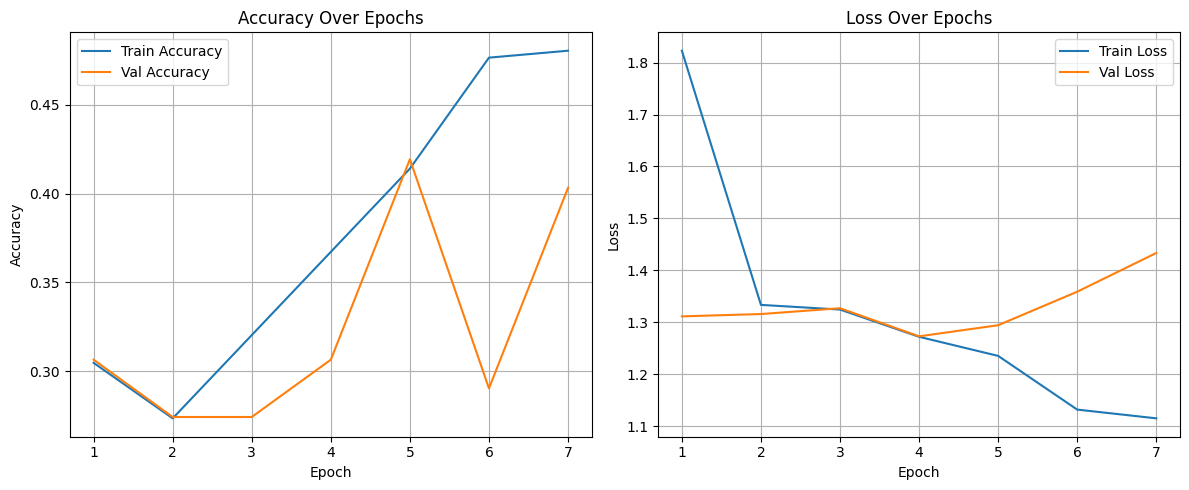

In [30]:
plot_training_history(history)

In [31]:
mobilenet_base=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))

mobile_model=models.Sequential([
    layers.Rescaling(1./255,input_shape=(224,224,3)),
    mobilenet_base,
    layers.GlobalAveragePooling2D(), #This layer compresses the feature maps (which come out of MobileNet) into a single vector per image.
    layers.Dense(128,activation='relu'),
      layers.Dropout(0.3),  # Randomly “turns off” 50% of neurons during training.
    layers.Dense(4,activation='softmax')


])

In [32]:
mobilenet_base.trainable=True   # by default all training is freeze bcoz u loaded pretrained model like imagenet, this unfreezes to train and improve accuracy
for layers in mobilenet_base.layers[:100]:
  layers.trainable=False
# Even though you unfreezed all layers above, here you're freezing the first 100 layers again. These early layers detect very general features (like edges, curves, etc.) which are already useful and don’t need re-training.
mobile_model.compile(loss=('categorical_crossentropy'),# sparse_categorical_crossentropy is used for multi-class classification with integer labels.
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy'])


In [33]:
mobile_history = mobile_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2688 - loss: 1.4252 - val_accuracy: 0.3387 - val_loss: 2.0728 - learning_rate: 1.0000e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3086 - loss: 1.3716 - val_accuracy: 0.3387 - val_loss: 2.0427 - learning_rate: 1.0000e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3068 - loss: 1.3237 - val_accuracy: 0.3387 - val_loss: 2.1037 - learning_rate: 1.0000e-04
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3797 - loss: 1.3065 - val_accuracy: 0.3387 - val_loss: 2.2006 - learning_rate: 1.0000e-04
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.3166 - loss: 1.2800 - val_accuracy: 0.3387 - val_loss: 2.2275 - learning_rate: 1.0000e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3506 - loss: 1.2780 - val_accuracy: 0.3387 - val_loss: 2.1727 - learning_rate: 2.0000e-05


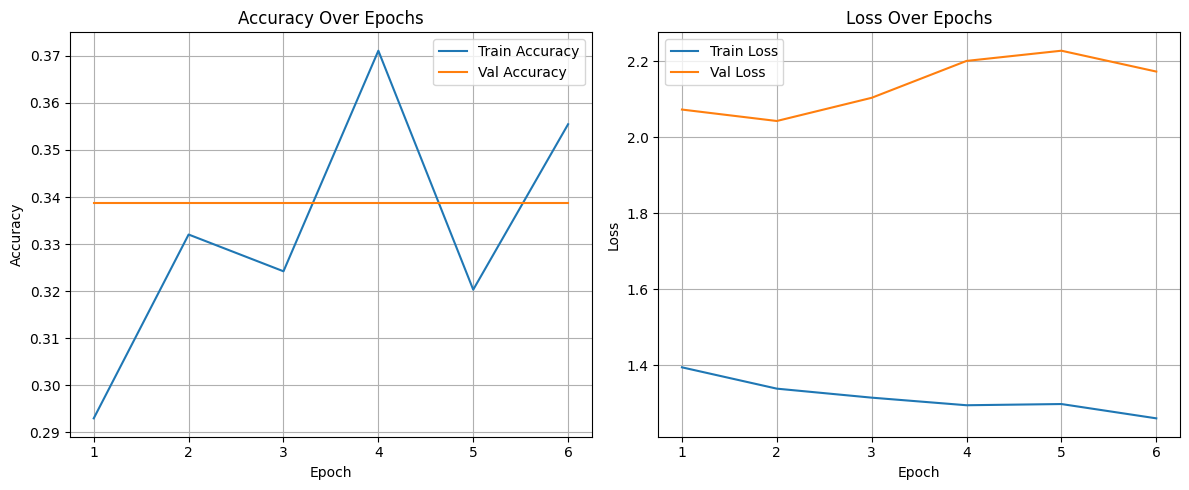

In [34]:
plot_training_history(mobile_history)

In [35]:

from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models

# Make sure class_names is a list of your categories
# class_names = ['guitar', 'flute', 'piano', ...]

# Load the EfficientNetB7 base model without the top layer
efficient_b7_base = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Build the model
efficient_b7_model = models.Sequential([
    layers.Lambda(preprocess_input, input_shape=(224, 224, 3)),  # Preprocess input
    efficient_b7_base,                                            # Base model
    layers.BatchNormalization(),                                  # Normalize features
    layers.GlobalAveragePooling2D(),                              # Flatten to vector
    layers.Dense(128, activation='relu'),                         # Fully connected layer
    layers.Dropout(0.3),                                          # Prevent overfitting
    layers.Dense(4, activation='softmax')          # Output layer
])


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [36]:
efficient_b7_base.trainable=True



# compile sets the rules of what to learn
efficient_b7_model.compile(
    loss=('categorical_crossentropy'), #
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # adam optimizer is used to learn quickly and effiecently and 0001 is that model will learn slowly and effiecntly
    metrics=['accuracy']
)

In [37]:
efficient_b7_base_history=efficient_b7_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 716s 53s/step - accuracy: 0.2881 - loss: 1.4223 - val_accuracy: 0.2581 - val_loss: 1.3425 - learning_rate: 1.0000e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 392s 49s/step - accuracy: 0.7039 - loss: 0.9357 - val_accuracy: 0.3387 - val_loss: 1.3285 - learning_rate: 1.0000e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 426s 47s/step - accuracy: 0.8573 - loss: 0.5896 - val_accuracy: 0.3387 - val_loss: 1.3254 - learning_rate: 1.0000e-04
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 378s 47s/step - accuracy: 0.9494 - loss: 0.3318 - val_accuracy: 0.3387 - val_loss: 1.3256 - learning_rate: 1.0000e-04
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 376s 47s/step - accuracy: 0.9754 - loss: 0.2095 - val_accuracy: 0.3387 - val_loss: 1.3285 - learning_rate: 1.0000e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 375s 46s/step - accuracy: 0.9846 - loss: 0.1115 - val_accuracy: 0.3387 - val_loss: 1.3336 - learning_rate: 1.0000e-04


In [38]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_skin_type(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_labels = list(train_gen.class_indices.keys())
    return class_labels[class_index]

# Example
# print(predict_skin_type("/content/dry_skin.webp"))


FileNotFoundError: [Errno 2] No such file or directory: '/content/dry_skin.webp'